In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from plot_func import *

## Section 1: Reading the data

In [25]:
df = pd.read_csv('../../Census-Income-KDD.csv')
print(df.shape)

(199523, 42)


In [26]:
df.columns

Index(['age', 'class_worker', 'det_ind_code', 'det_occ_code', 'education',
       'wage_per_hour', 'hs_college', 'marital_stat', 'major_ind_code',
       'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member',
       'unemp_reason', 'full_or_part_emp', 'capital_gains', 'capital_losses',
       'stock_dividends', 'tax_filer_stat', 'region_prev_res',
       'state_prev_res', 'det_hh_fam_stat', 'det_hh_summ', 'unknown',
       'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same',
       'mig_prev_sunbelt', 'num_emp', 'fam_under_18', 'country_father',
       'country_mother', 'country_self', 'citizenship', 'own_or_self',
       'vet_question', 'vet_benefits', 'weeks_worked', 'year', 'income_50k'],
      dtype='object')

we drop the "unknown" column since it should not be used for classsifiers (from the dataset description).

In [27]:
df = df.drop('unknown', axis=1)

in our case, the target variable is "income_50k" and the rest of the variables are the features.

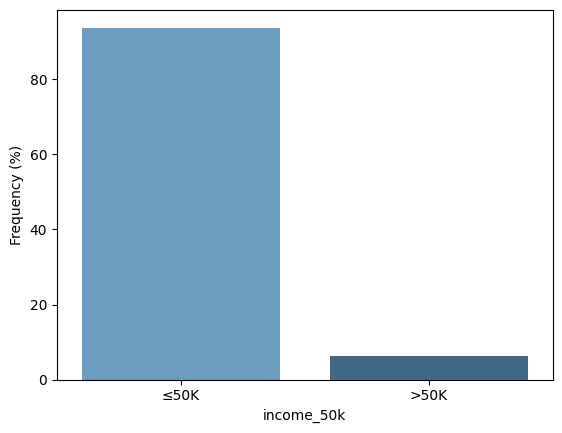

In [28]:
barplot(df)

## Section 2: Basic inspection of the data

In [29]:
df.describe()

,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,vet_benefits,weeks_worked,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


In [30]:
# count column types
df.dtypes.value_counts()

object    29
int64     12
Name: count, dtype: int64

<Axes: >

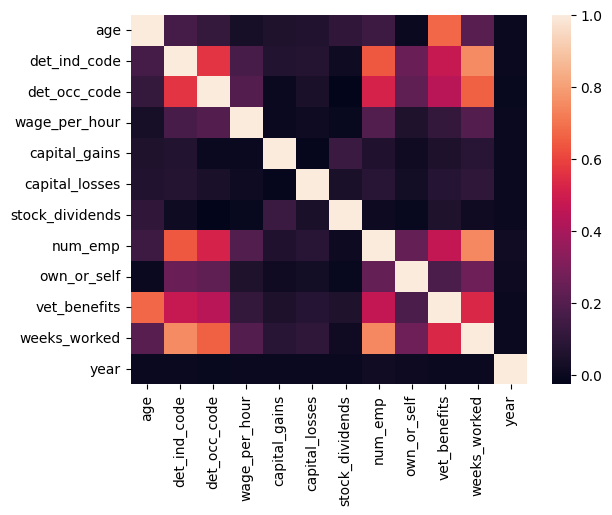

In [31]:
# heatmap of the correlation between the numerical features
corr = df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

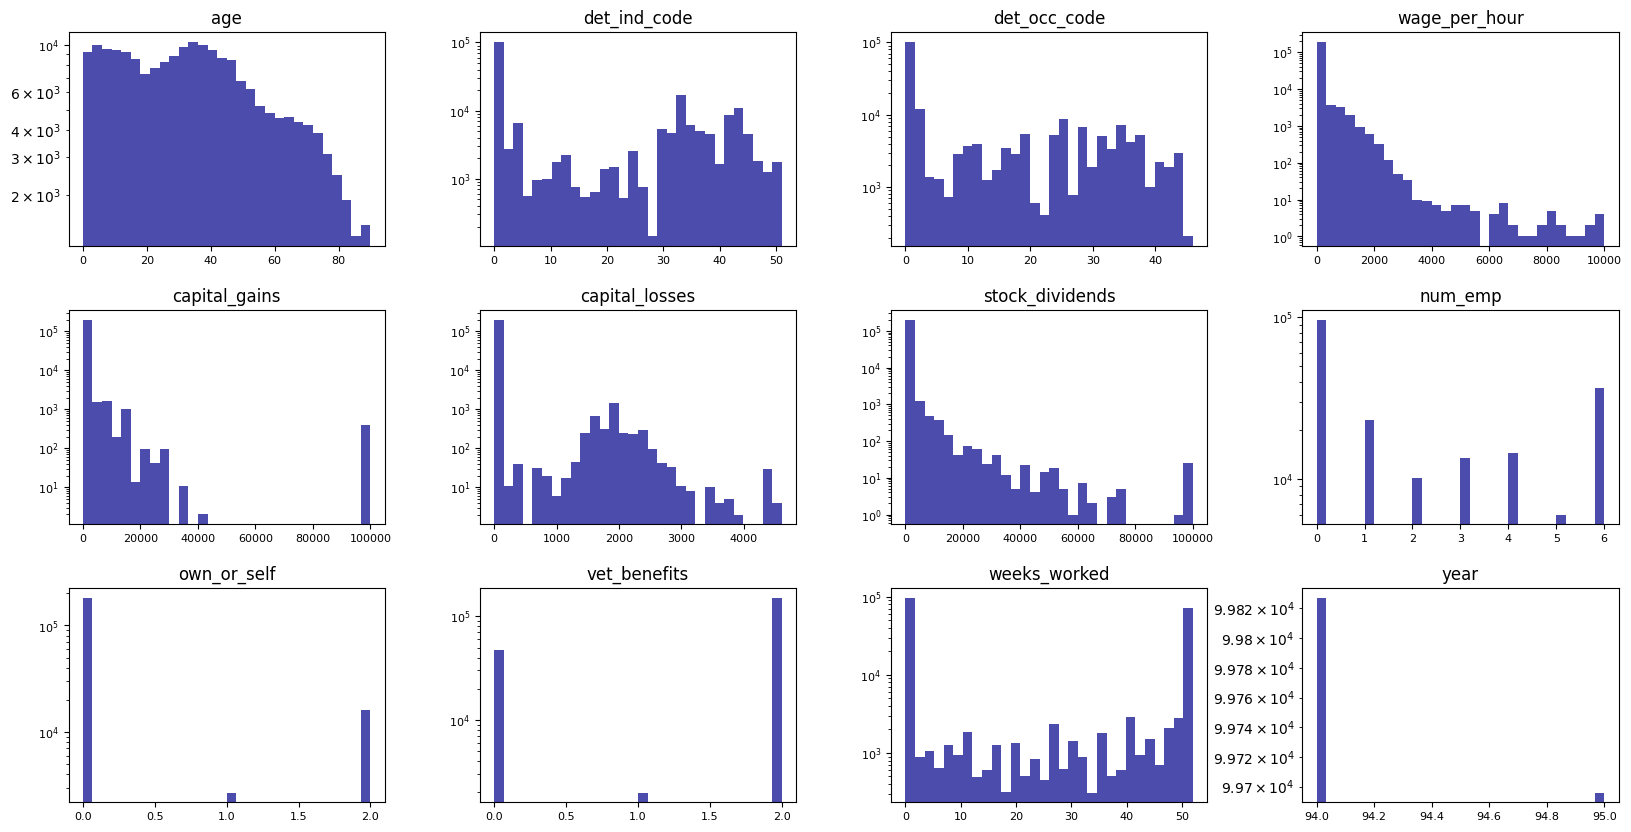

In [32]:
df.hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, log=True,
        layout=(3,4), color='darkblue', alpha=0.7, grid=False)
plt.show()

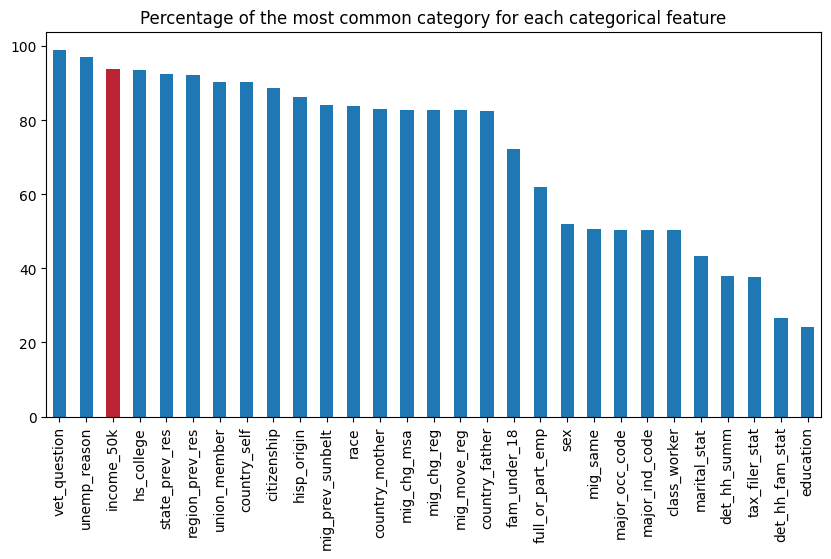

In [33]:
a = df.select_dtypes(include=['object']).apply(lambda x: x.value_counts(normalize=True).max()*100)
a = a.sort_values(ascending=False)
a.plot(kind='bar', figsize=(10,5))
plt.bar(a.index.get_loc('income_50k'), a['income_50k'], color='red', width=0.5, label='income_50k', alpha=0.7)
plt.title('Percentage of the most common category for each categorical feature')
plt.show()

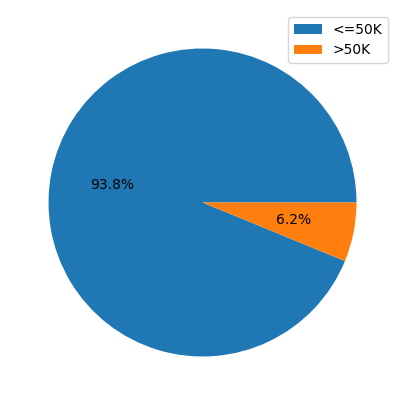

In [34]:
# pieplot of income_50k, change the names of - 50000. and 50000+. to <=50K and >50K
df['income_50k'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), labels=['', ''])
plt.legend(labels=['<=50K', '>50K'])
plt.ylabel('')
plt.show()

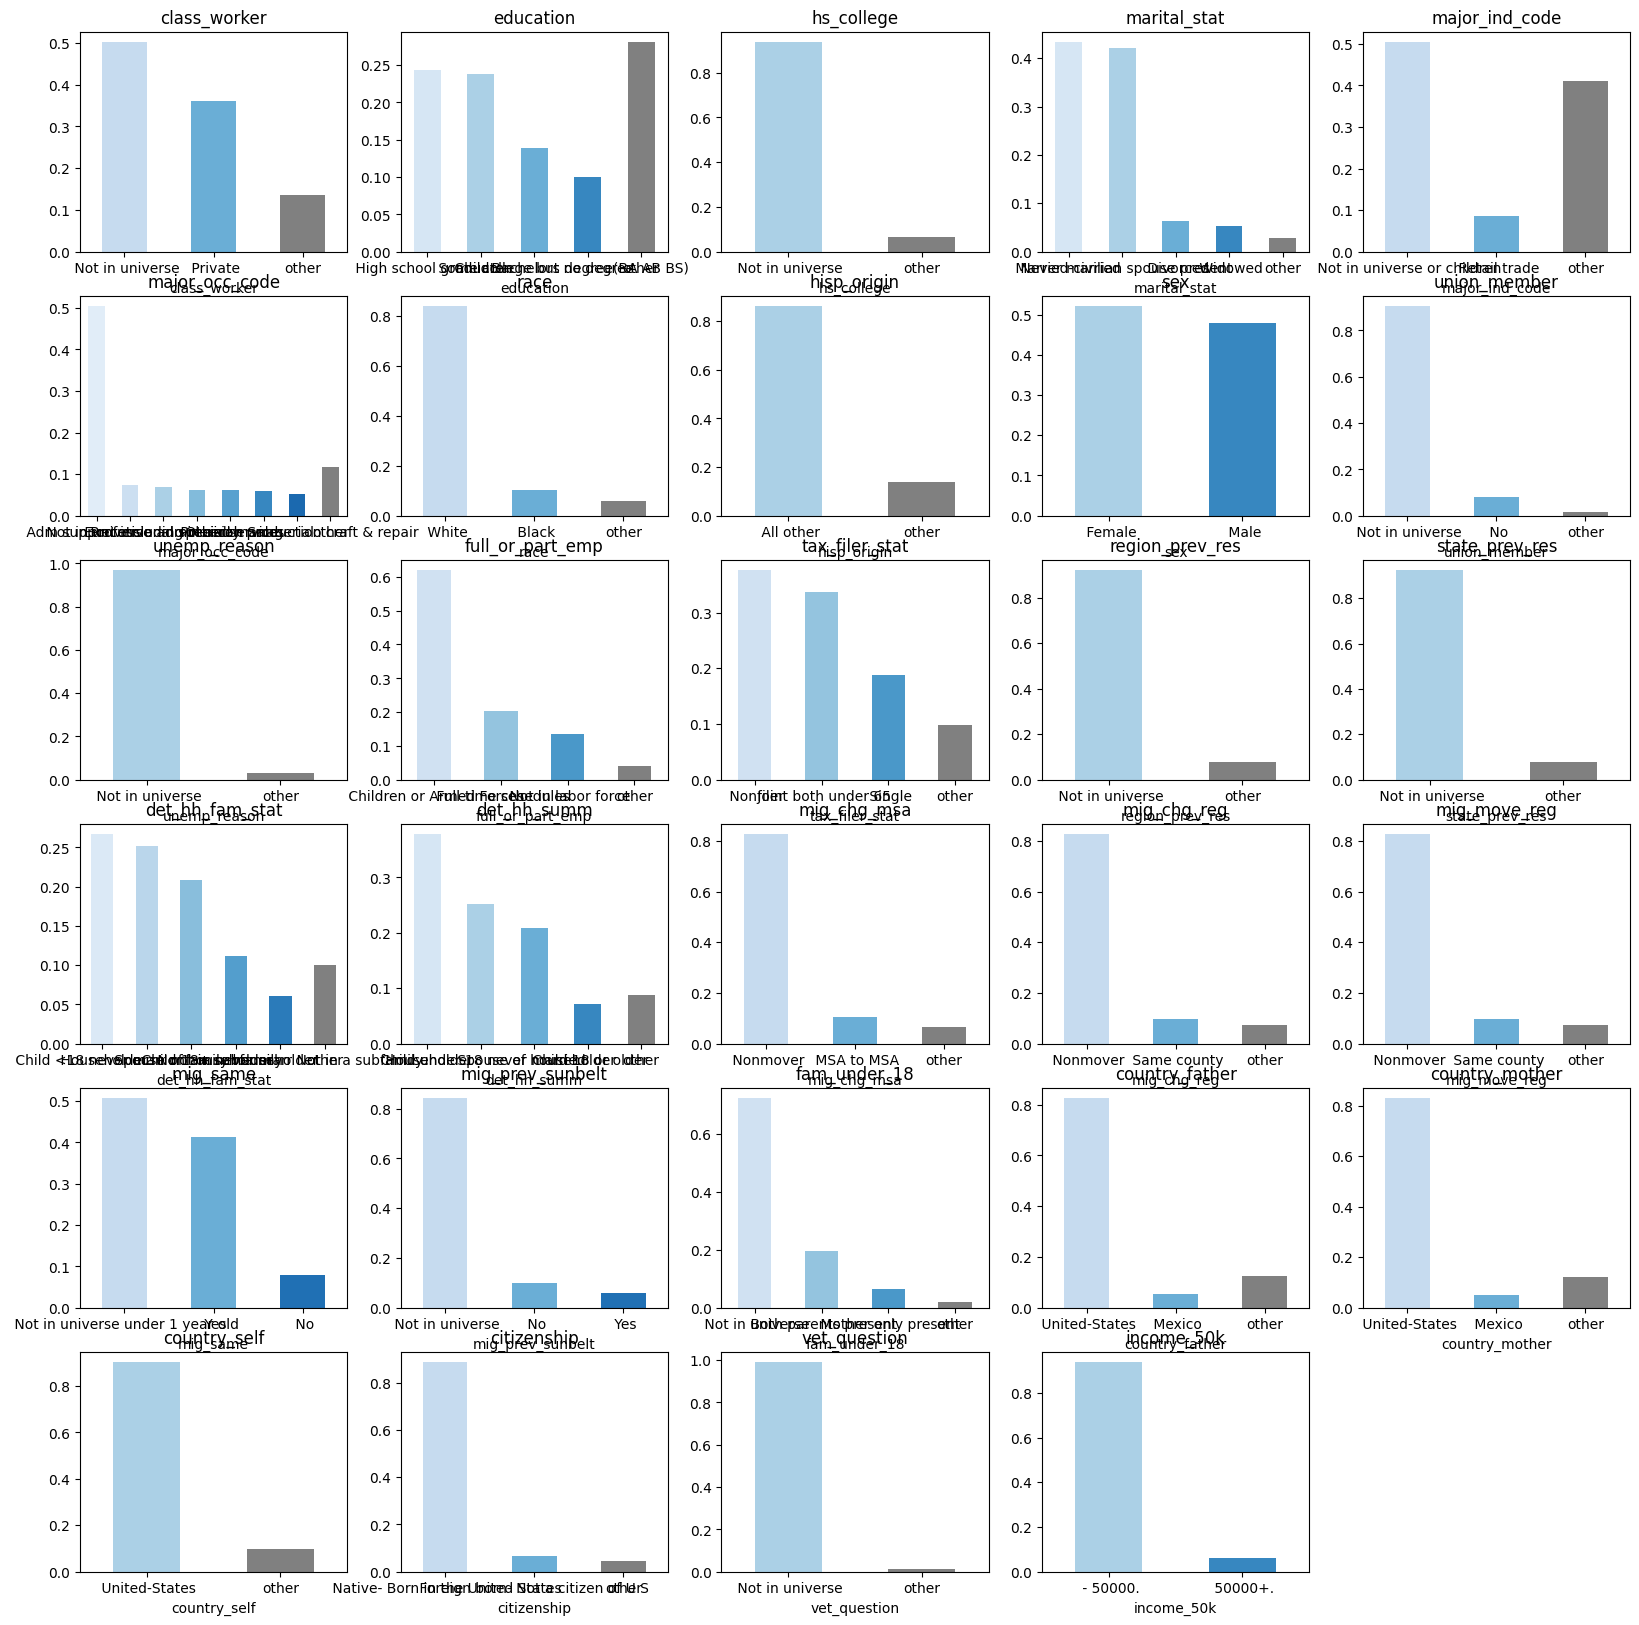

In [35]:
cat_col = df.select_dtypes(include=['object']).columns
barplots(df, cat_col, figsize=(20, 20))

Number of rows with age 0:  2839


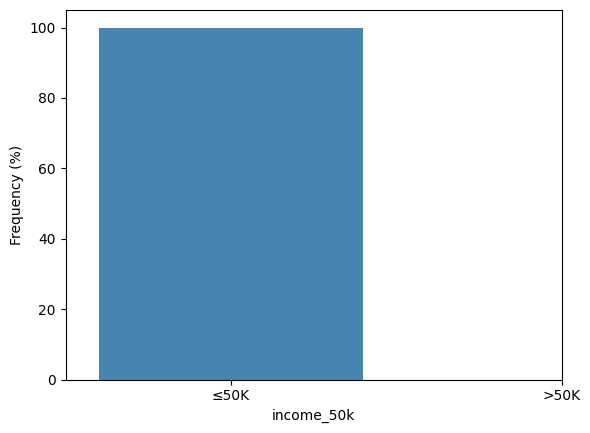

In [36]:
print("Number of rows with age 0: ", df[df['age'] == 0].shape[0])
barplot(df[df['age'] == 0])

as expected, all the individuals with 0 years have an income below 50k.

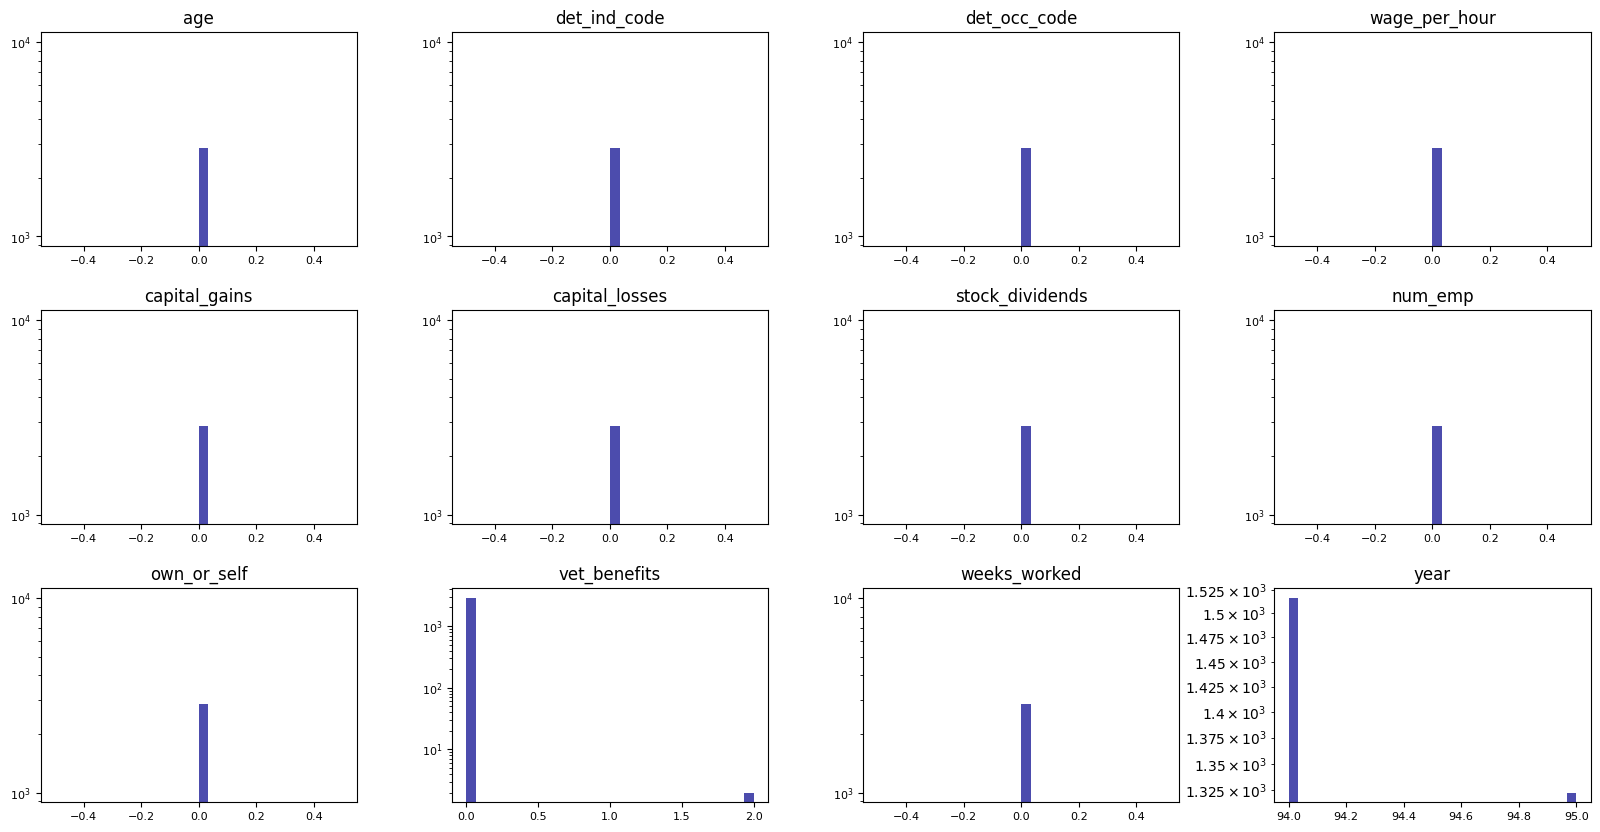

In [37]:
df[df['age'] == 0].hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, log=True,
        layout=(3,4), color='darkblue', alpha=0.7, grid=False)
plt.show()

The distribution for the rest of variables is coherent for a 0 years old person.

## Section 3: Data cleaning

In [38]:
df1 = df.copy()

To avoid having correlation between the rows, we drop the duplicates.

In [39]:
# show the number of duplicates
print(f"Number of duplicates: {df1.duplicated().sum()}")
df1 = df1.drop_duplicates()
print(f"Number of rows after removing duplicates: {df1.shape[0]}")

Number of duplicates: 46627
Number of rows after removing duplicates: 152896


### Missing values detection

In [40]:
df1.describe()

,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,vet_benefits,weeks_worked,year
count,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000
mean,39.719371,19.942922,14.672876,72.324279,567.237115,48.664471,257.019255,2.538052,0.228587,1.821061,30.061591,94.490163
std,19.662074,18.234760,14.887964,312.072448,5359.204656,309.511387,2261.405280,2.403920,0.622317,0.559472,23.786471,0.499905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,38.000000,24.000000,10.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,45.000000,94.000000
75%,52.000000,37.000000,29.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


<Axes: >

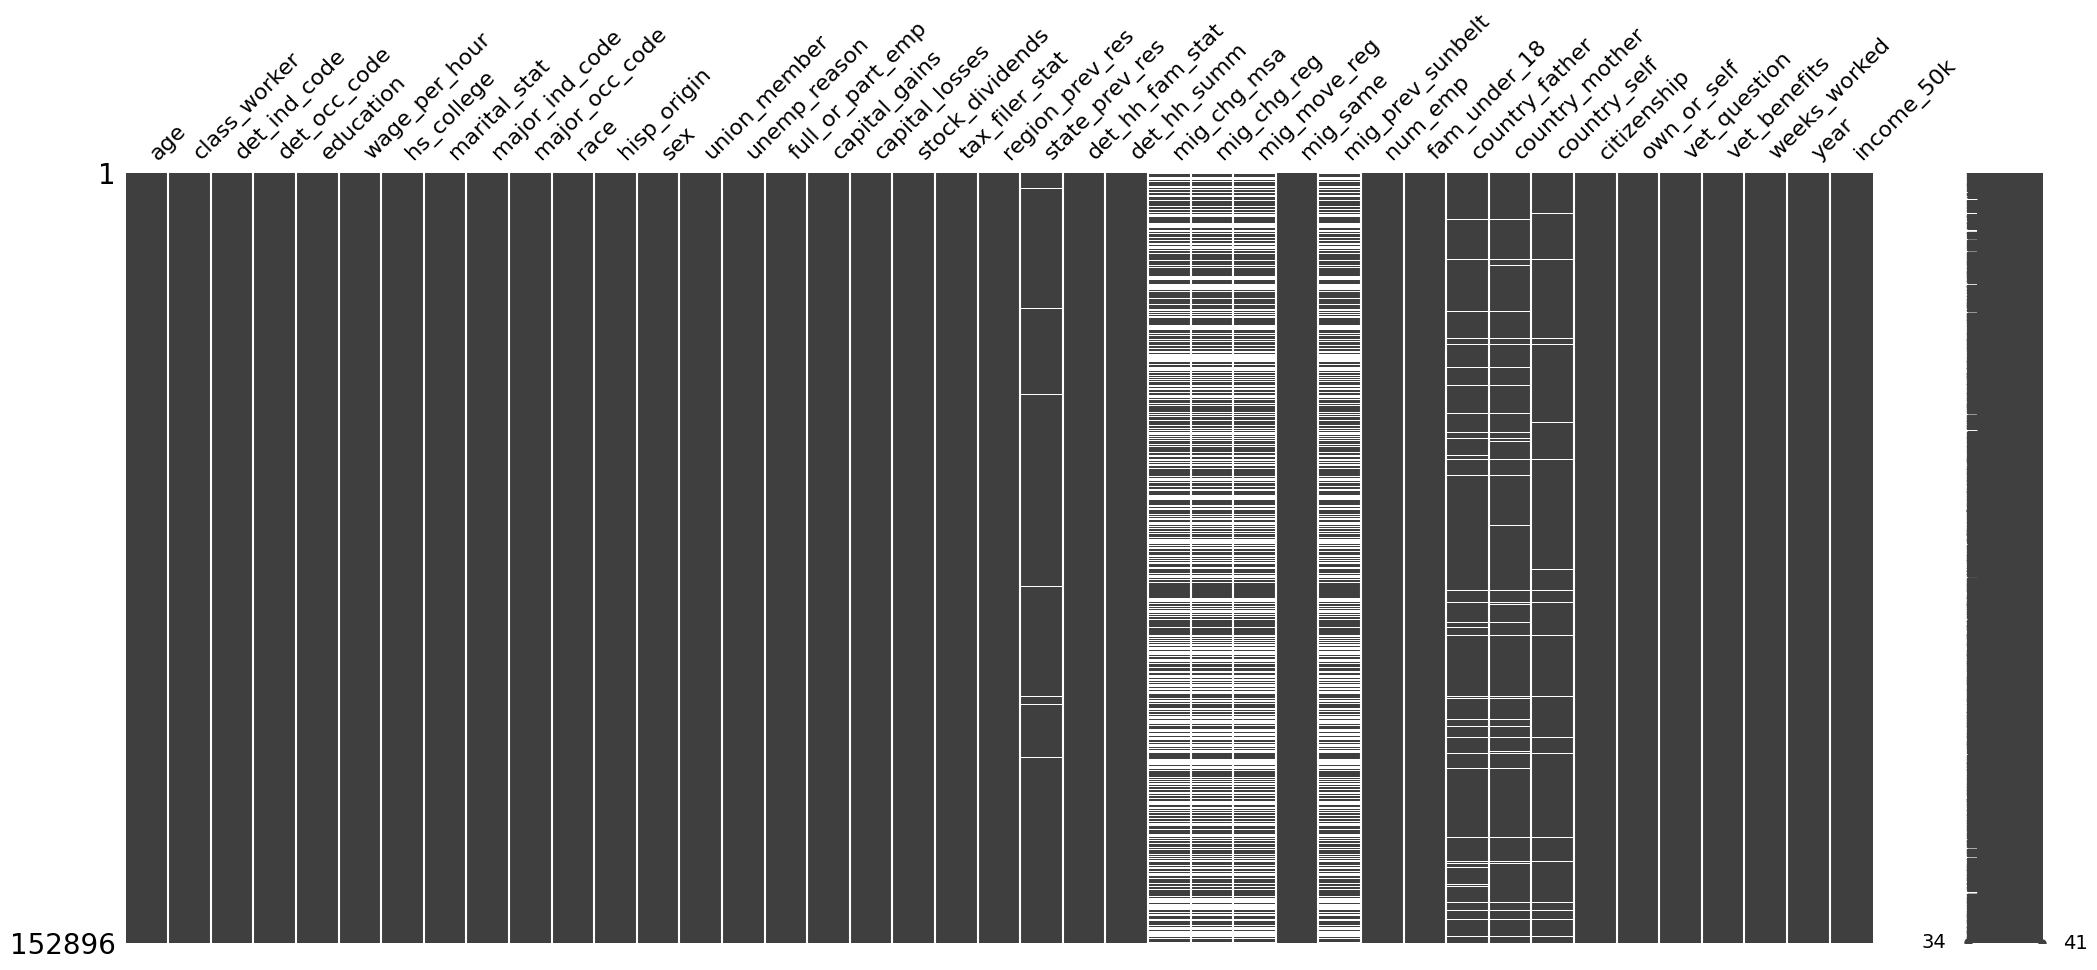

In [41]:
# plot the missing values
import missingno as msno
msno.matrix(df1)

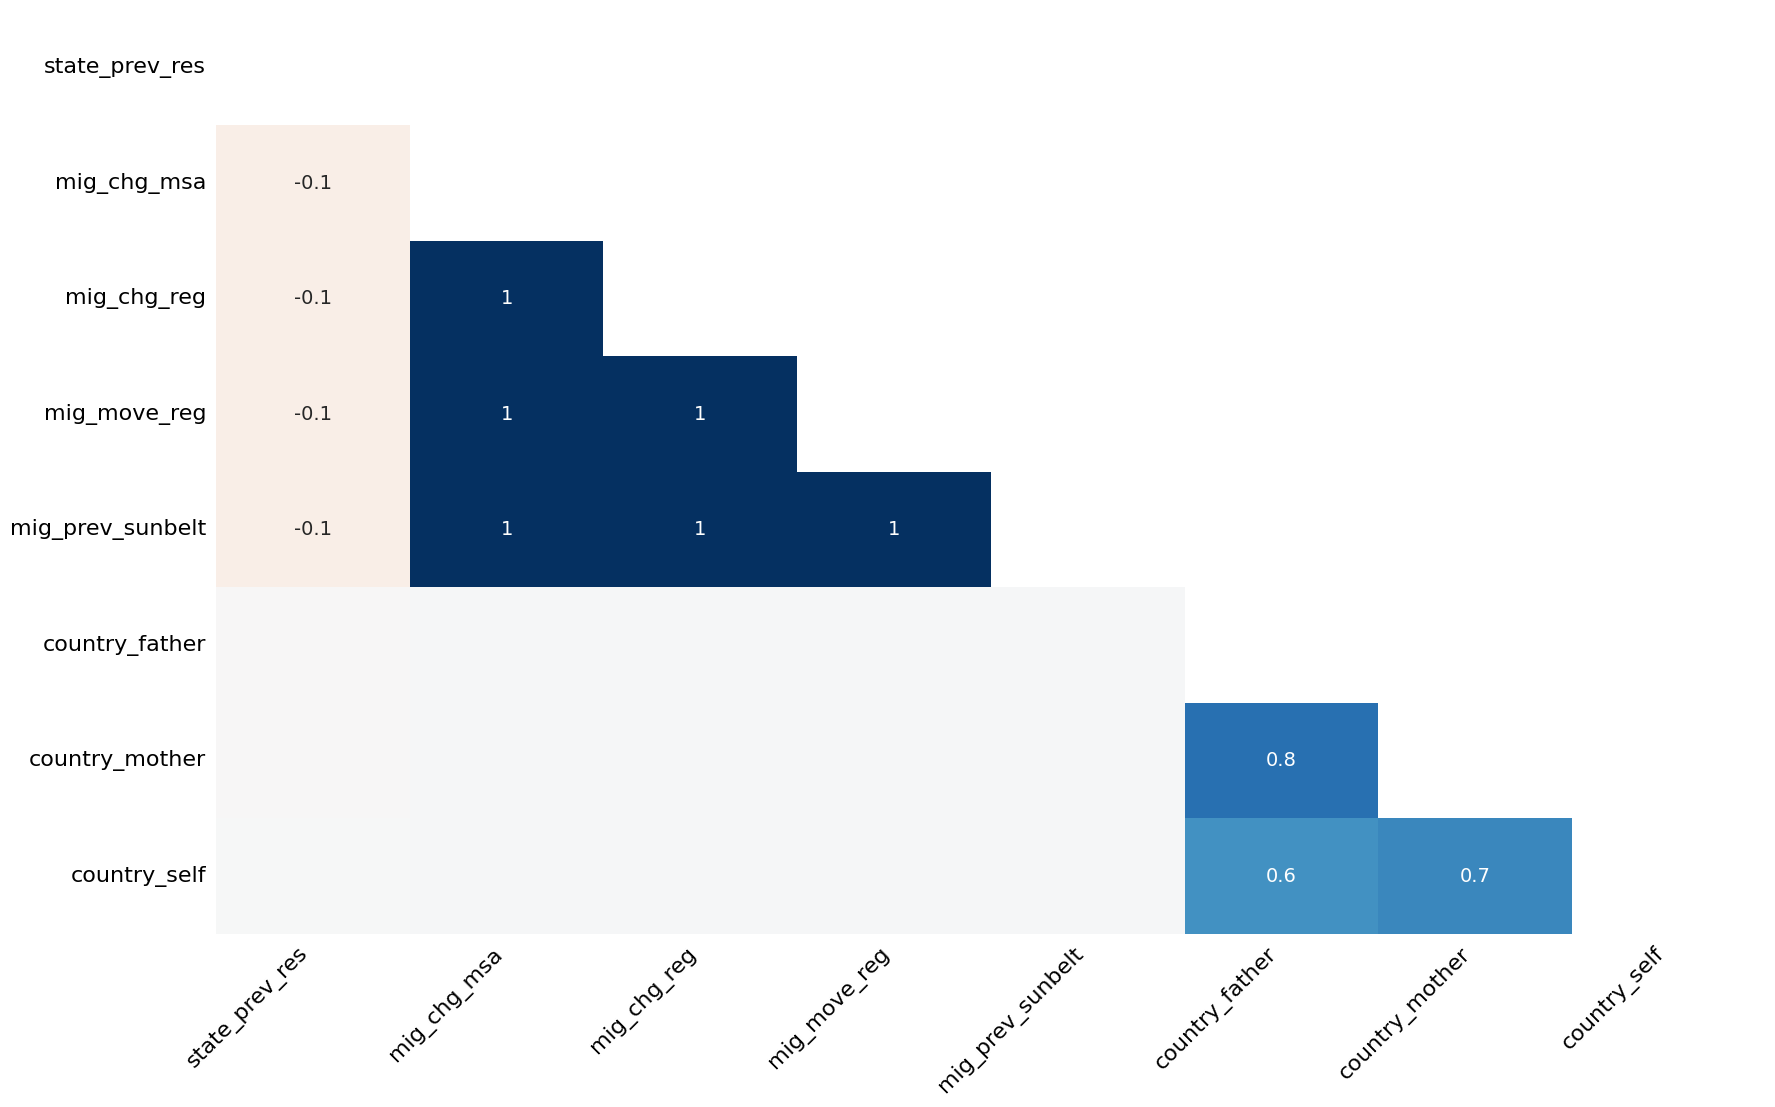

In [42]:
# plot the correlation between the missing values without the colorbar
msno.heatmap(df1, cbar=False)
plt.show()

We can see that the categories "mig_chg_msa", "mig_chg_reg", and "mig_move_reg" have a correlation of 1 with the target variable.

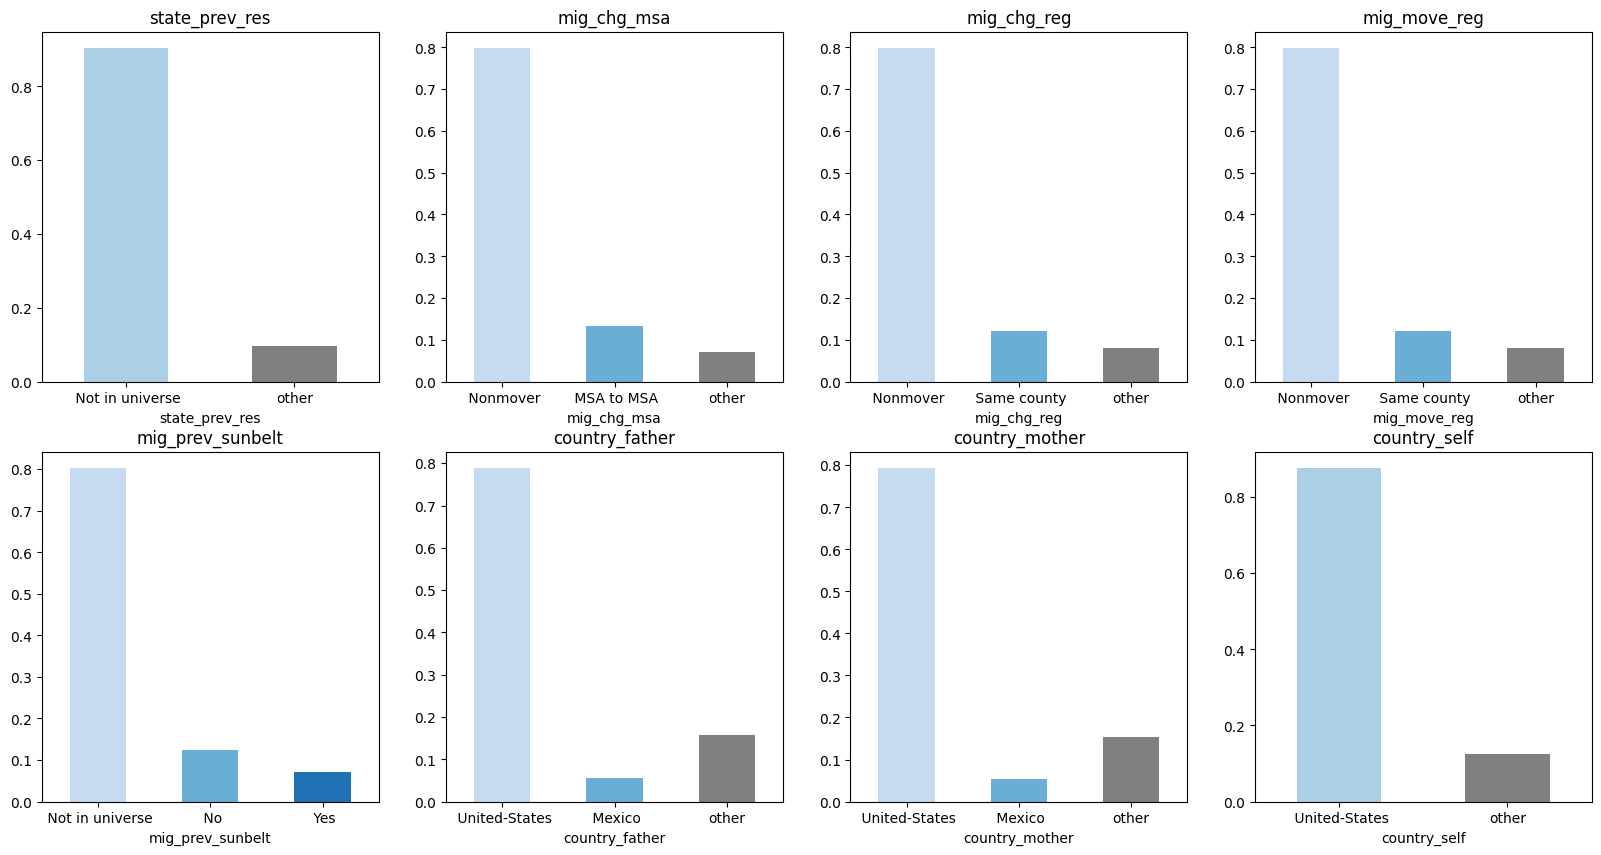

In [43]:
cols_with_missing = df1.columns[df1.isnull().any()]
barplots(df1, cols_with_missing, grid=(2,4), figsize=(20, 10))

### Treating missing values

In [44]:
print("Percentage of missing values per column:")
print(df1.isnull().sum()[df1.isnull().sum() > 0] / df1.shape[0])

Percentage of missing values per column:
state_prev_res      0.004565
mig_chg_msa         0.490163
mig_chg_reg         0.490163
mig_move_reg        0.490163
mig_prev_sunbelt    0.490163
country_father      0.041747
country_mother      0.038000
country_self        0.021727
dtype: float64


Missing values per year:

In [45]:
print("Percentage of missing values for the year 1994")
print(df1[df1['year'] == 94].isnull().sum()[df1[df1['year'] == 94].isnull().sum() > 0] / df1[df1['year'] == 94].shape[0])
print("Percentage of missing values for the year 1995")
print(df1[df1['year'] == 95].isnull().sum()[df1[df1['year'] == 95].isnull().sum() > 0] / df1[df1['year'] == 95].shape[0])

Percentage of missing values for the year 1994
state_prev_res    0.008954
country_father    0.040050
country_mother    0.036420
country_self      0.020320
dtype: float64
Percentage of missing values for the year 1995
mig_chg_msa         1.000000
mig_chg_reg         1.000000
mig_move_reg        1.000000
mig_prev_sunbelt    1.000000
country_father      0.043512
country_mother      0.039643
country_self        0.023191
dtype: float64


In [46]:
# we drop the columns with more than 40% of missing values
print(f"dropping columns: {cols_with_missing[df1[cols_with_missing].isnull().mean() > 0.4]}")
df1 = df1.drop(cols_with_missing[df1[cols_with_missing].isnull().mean() > 0.4], axis=1)
print(df1.isnull().sum()[df1.isnull().sum() > 0] / df1.shape[0])
cols_with_missing = df1.columns[df1.isnull().any()]

dropping columns: Index(['mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_prev_sunbelt'], dtype='object')
state_prev_res    0.004565
country_father    0.041747
country_mother    0.038000
country_self      0.021727
dtype: float64


<Axes: xlabel='state_prev_res'>

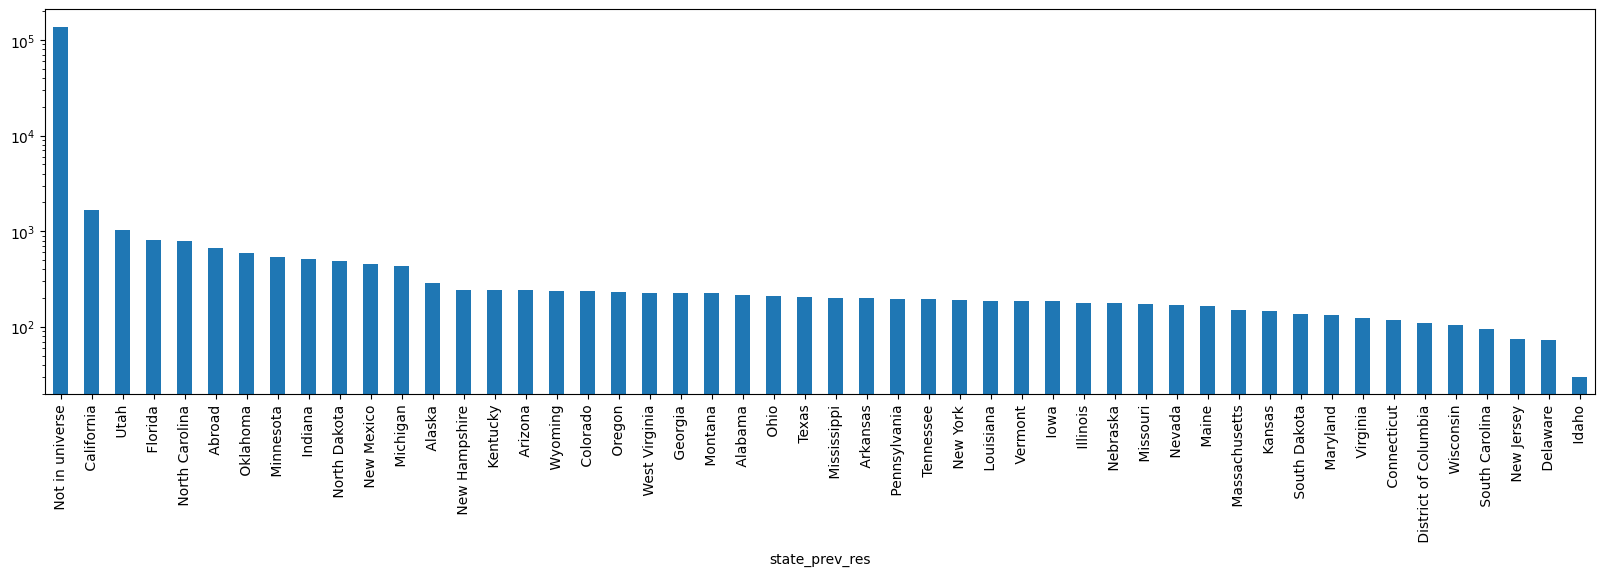

In [47]:
df1['state_prev_res'].value_counts().plot(kind='bar', logy=True, figsize=(20, 5))

since the columns state_prev_res, country_father, country_mother, and country_self have less than 5% of missing values, we can imputate them with the most frequent value.

In [48]:
# we fill the missing values with the most frequent value
cols_with_missing = df1.columns[df1.isnull().any()]
print(cols_with_missing)
for col in cols_with_missing:
    df1[col] = df1[col].fillna(df1[col].value_counts().index[0])  
print(f"Missing values: {sum(df1.isnull().sum())}")

Index(['state_prev_res', 'country_father', 'country_mother', 'country_self'], dtype='object')
Missing values: 0


### Outlier treatment

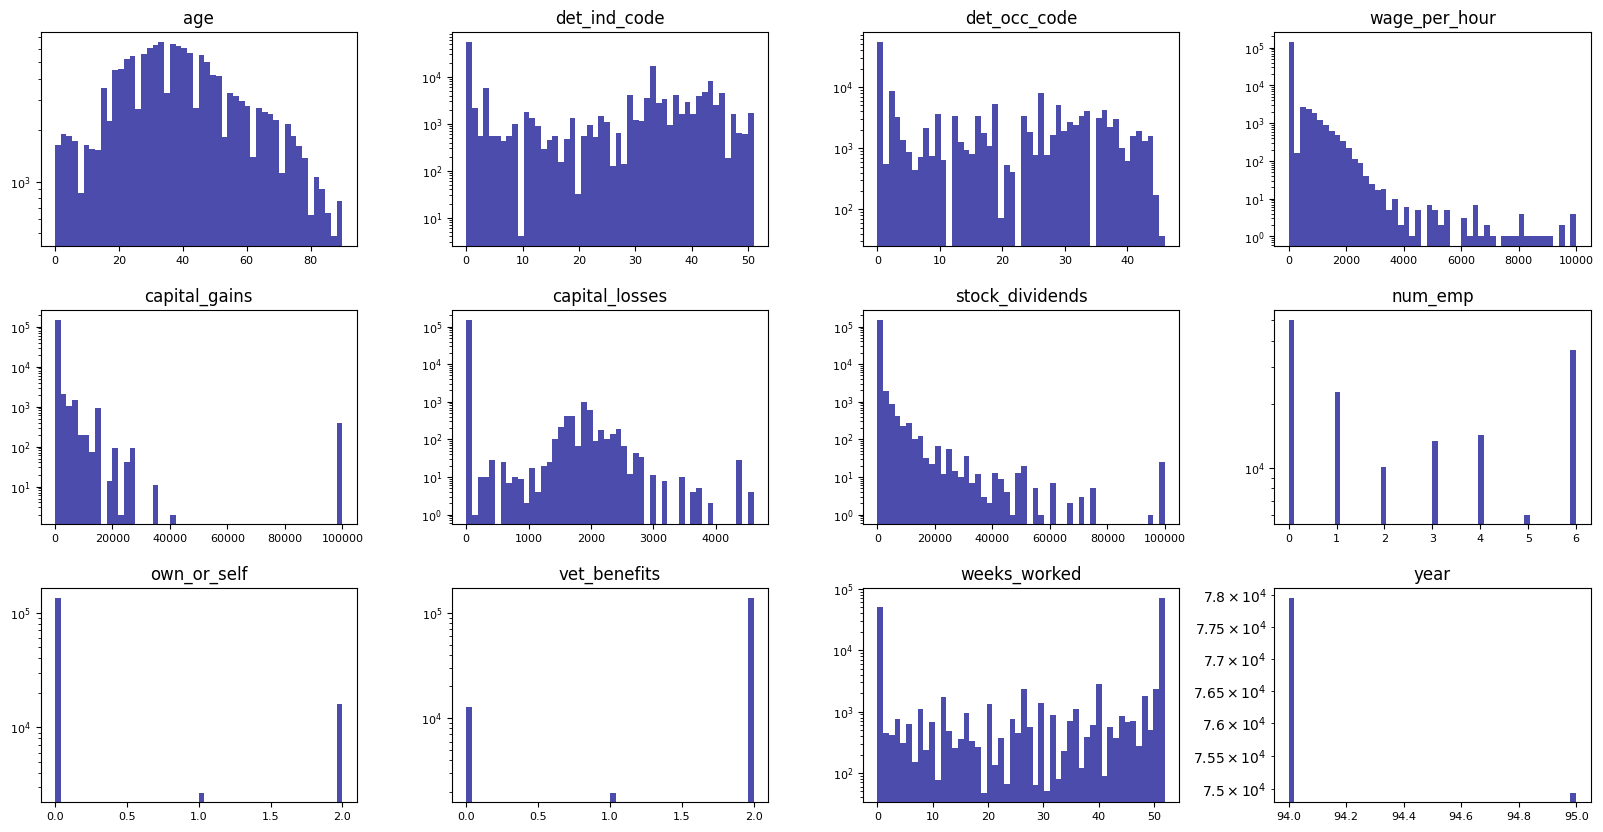

In [49]:
df1.hist(figsize=(20,10), bins=50, layout=(3, 4), log=True,
         xlabelsize=8, ylabelsize=8, grid=False, color='darkblue', alpha=0.7)
plt.show()

Alysis of capital gains, capital losses, wage per hour, and stock dividends:

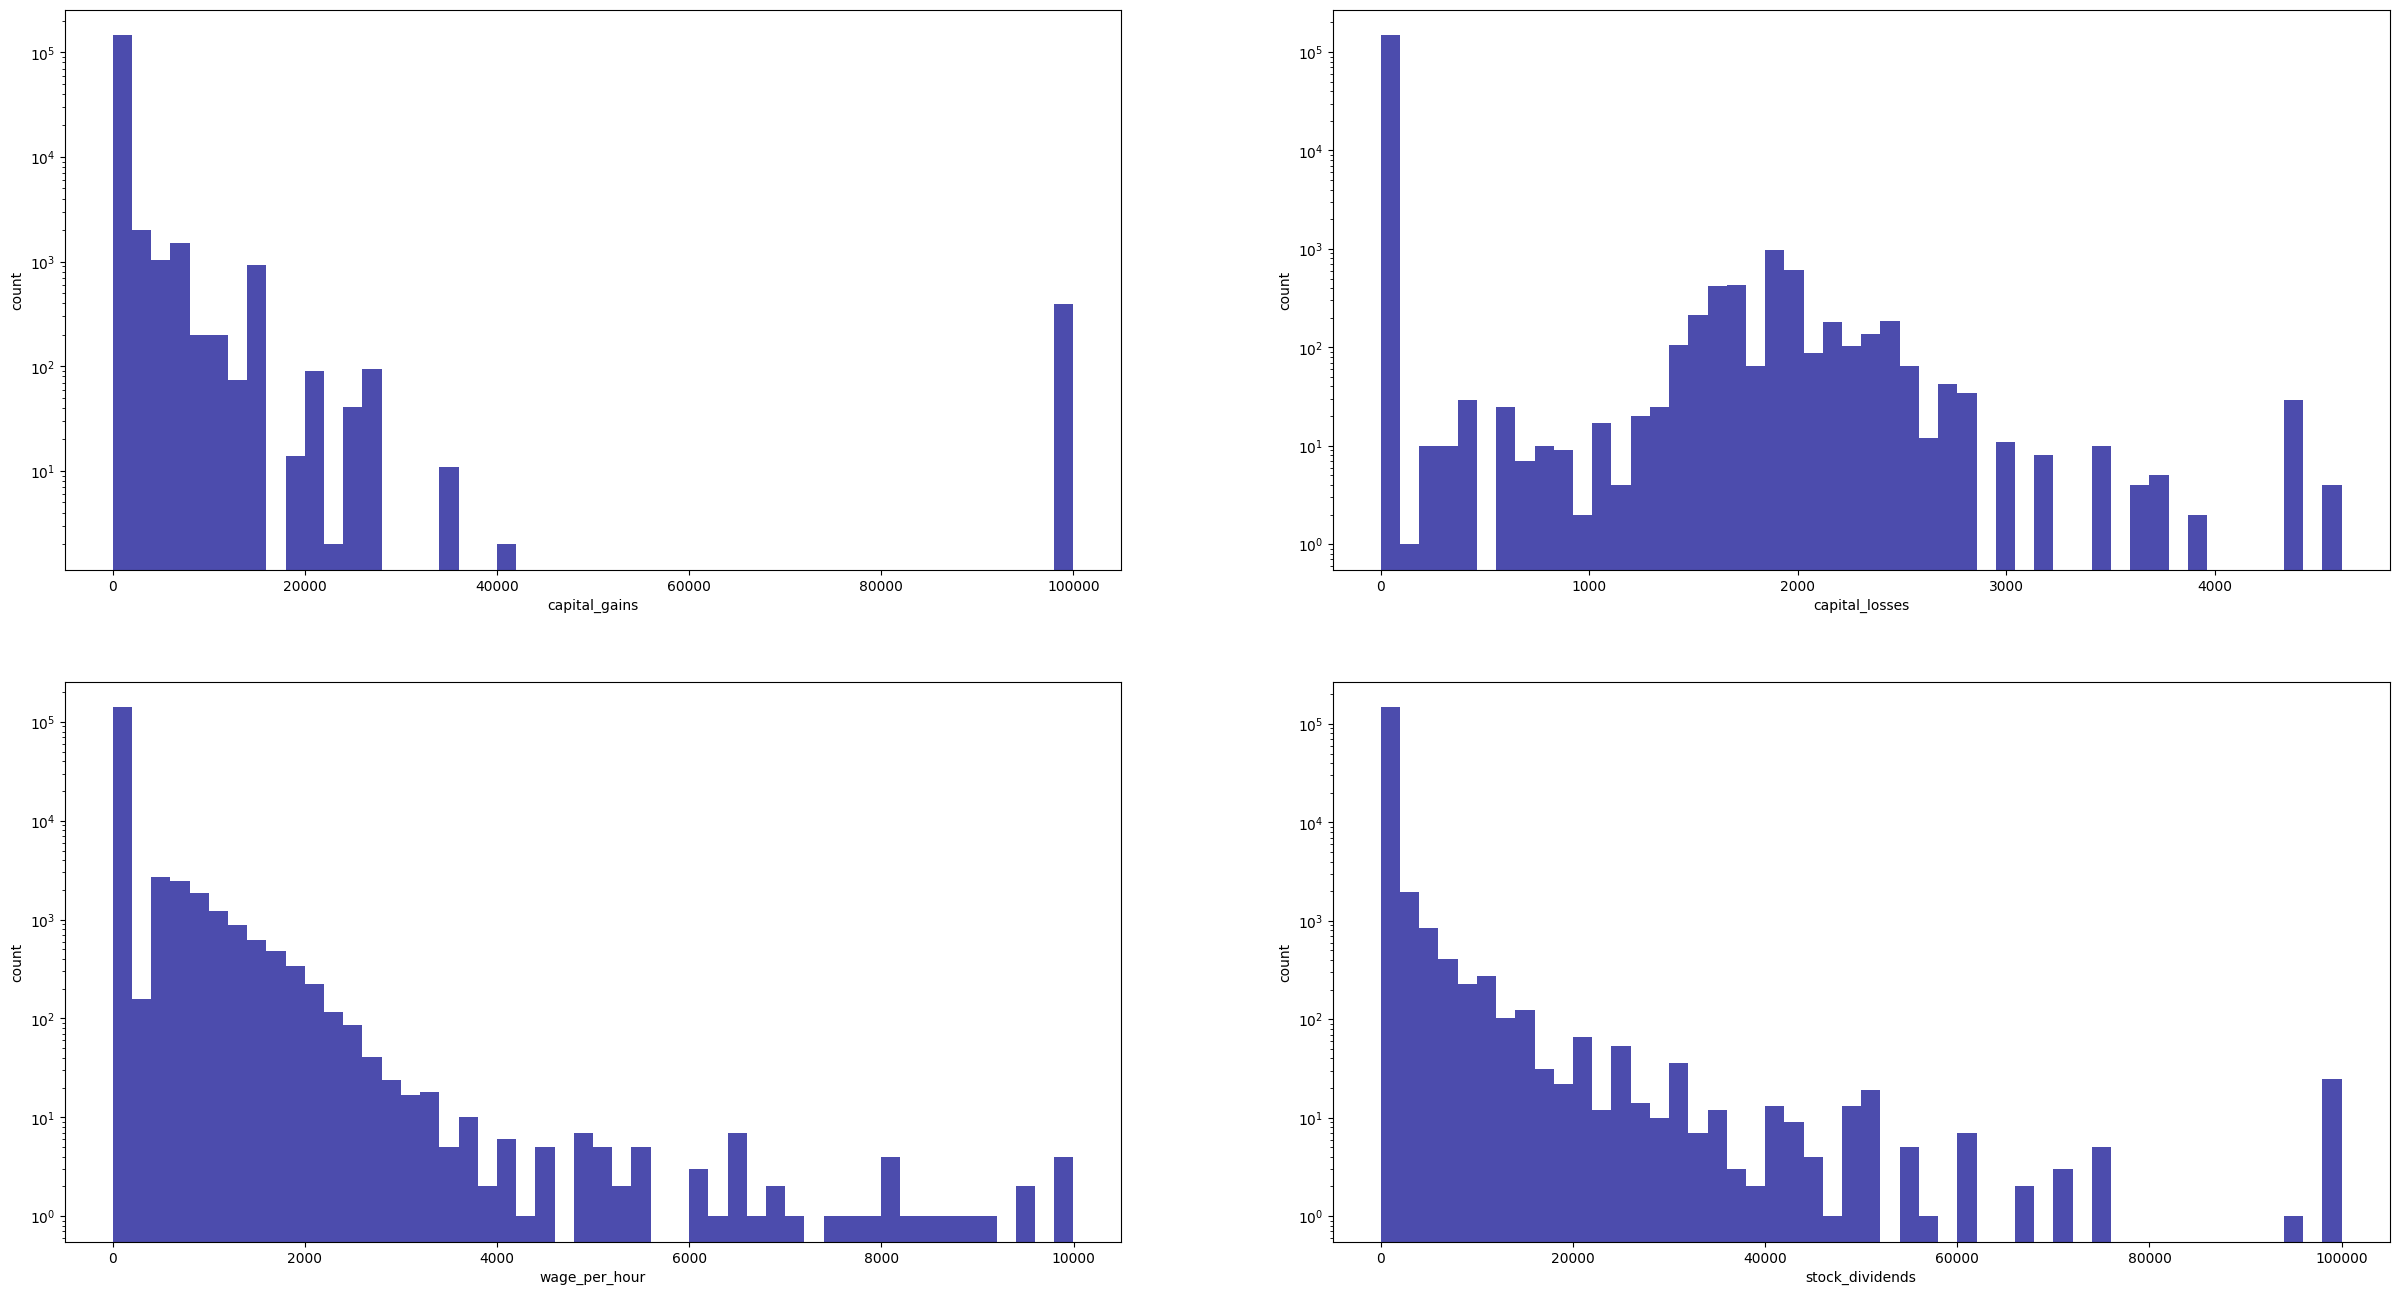

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(30, 16))
axes = axes.flatten()
for i, col in enumerate(['capital_gains', 'capital_losses', 'wage_per_hour', 'stock_dividends']):
    df1[col].plot(kind='hist', logy=True, bins=50, ax=axes[i], color='darkblue', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('count')
plt.show()

In [51]:
for col in ['capital_gains', 'capital_losses', 'wage_per_hour', 'stock_dividends']:
    print(f"Max value of {col}: {df1[col].max()} with count: {df1[df1[col] == df1[col].max()].shape[0]}")

Max value of capital_gains: 99999 with count: 390
Max value of capital_losses: 4608 with count: 4
Max value of wage_per_hour: 9999 with count: 1
Max value of stock_dividends: 99999 with count: 25


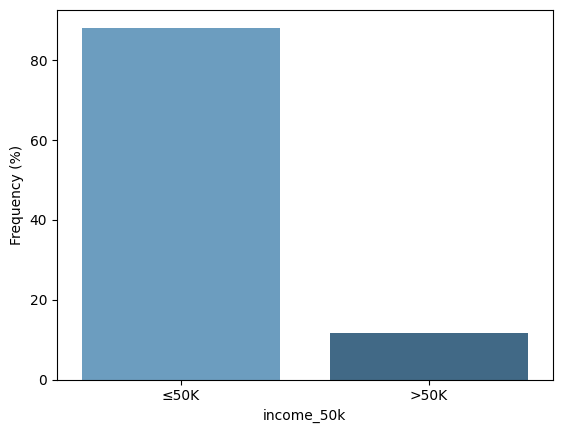

In [52]:
barplot(df1[df1['capital_gains'] == 99999])

We notice that the only values of capital_gains between the interval of 50k and 100k are 99999. We might think that this is because surely the maximum survey value for this column is 99999, however, we would expect most people with more than 99999 capital gains to have an income above 50k, however we see that this is not the case given that most individuals who have a capital gain of 99999 are in the <=50k bracket. This does not make much sense, so we can consider the 390 99999 values as outliers and eliminate them.
The features wage_per_hour and stock_dividends have a similar behaviour, so we will also eliminate the maximum values of these features.

In [53]:
print(f"Removing {sum((df1['capital_gains'] == 99999) | (df1['wage_per_hour'] == 9999) | (df1['stock_dividends'] == 99999))} rows") 
df1 = df1[(df1['capital_gains'] != 99999) & (df1['wage_per_hour'] != 9999) & (df1['stock_dividends'] != 99999)]

Removing 409 rows


### Converting numerical variables to categorical

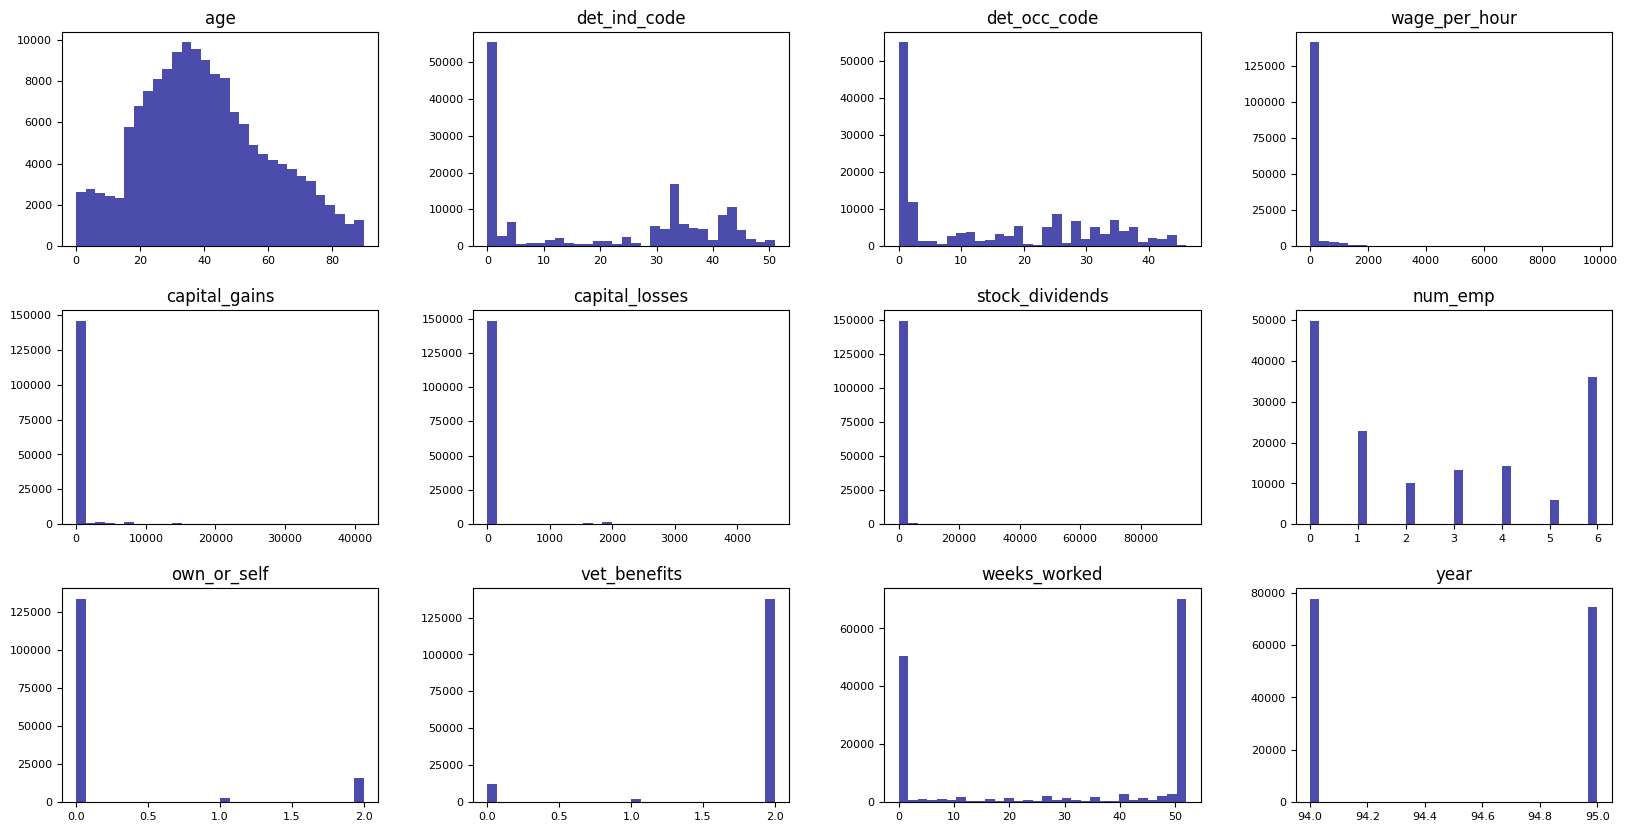

In [54]:
df1.hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, layout=(3,4), color='darkblue', alpha=0.7, grid=False)
plt.show()

In [55]:
# categorical columns hidden as numerical
for col in ['det_ind_code', 'det_occ_code', 'own_or_self', 'vet_benefits', 'year']:
    df1[col] = df1[col].astype('category')

In [56]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 105]
df1['age'] = pd.cut(df1['age'], bins=age_bins, labels=age_bins[:-1], include_lowest=True)

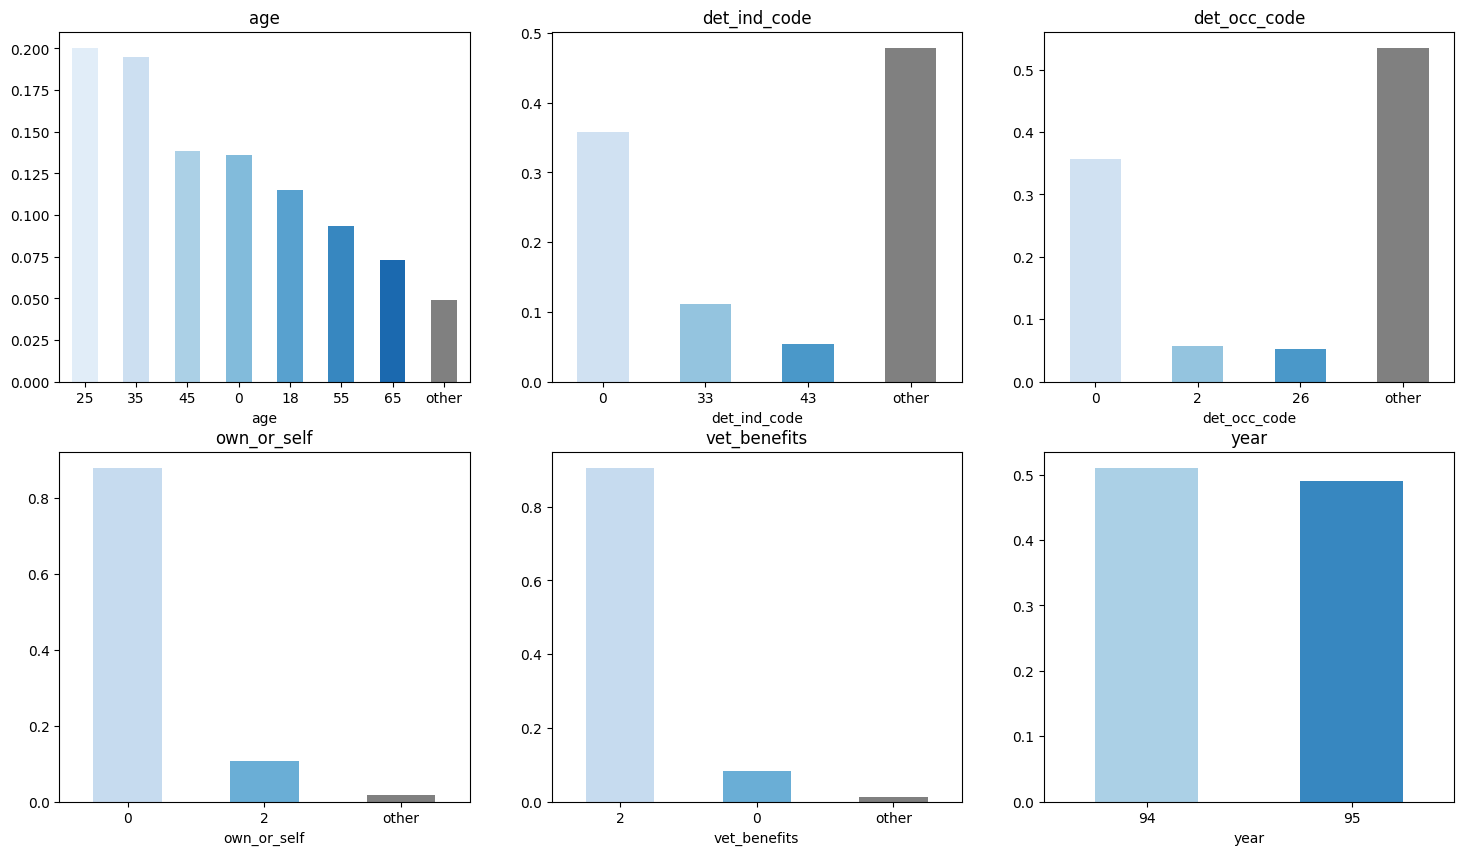

In [57]:
barplots(df1, ['age', 'det_ind_code', 'det_occ_code', 'own_or_self', 'vet_benefits', 'year'],
            grid=(2,3), figsize=(18, 10))

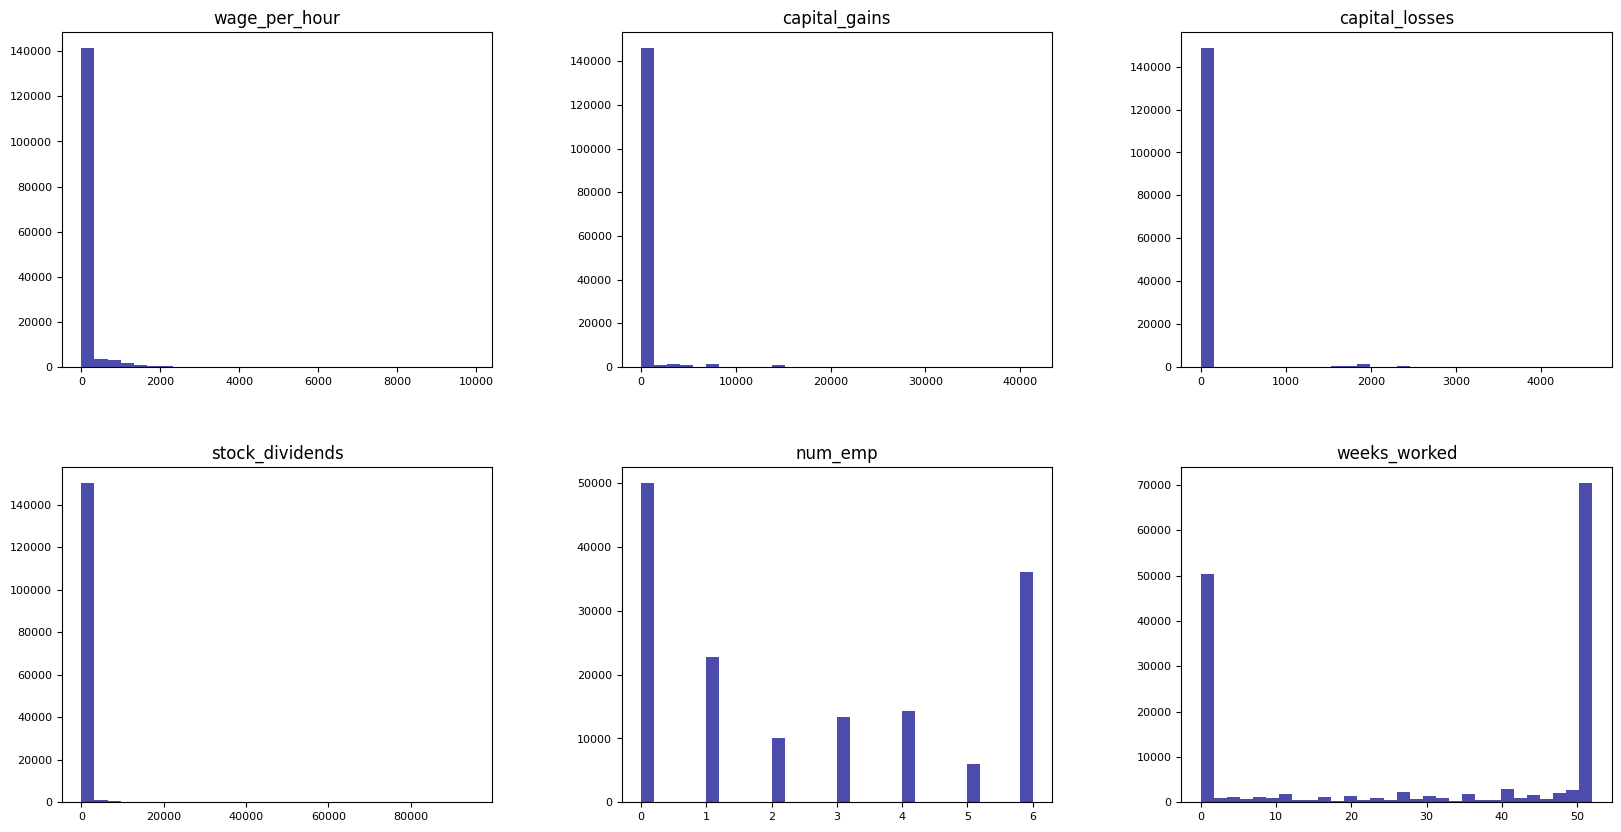

In [58]:
df1.hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, layout=(2, 3), color='darkblue', alpha=0.7, grid=False)
plt.show()

### Feature extraction

We can merge capital_gains and capital_losses into a new variable called "capital_balance" which is the difference between the two.

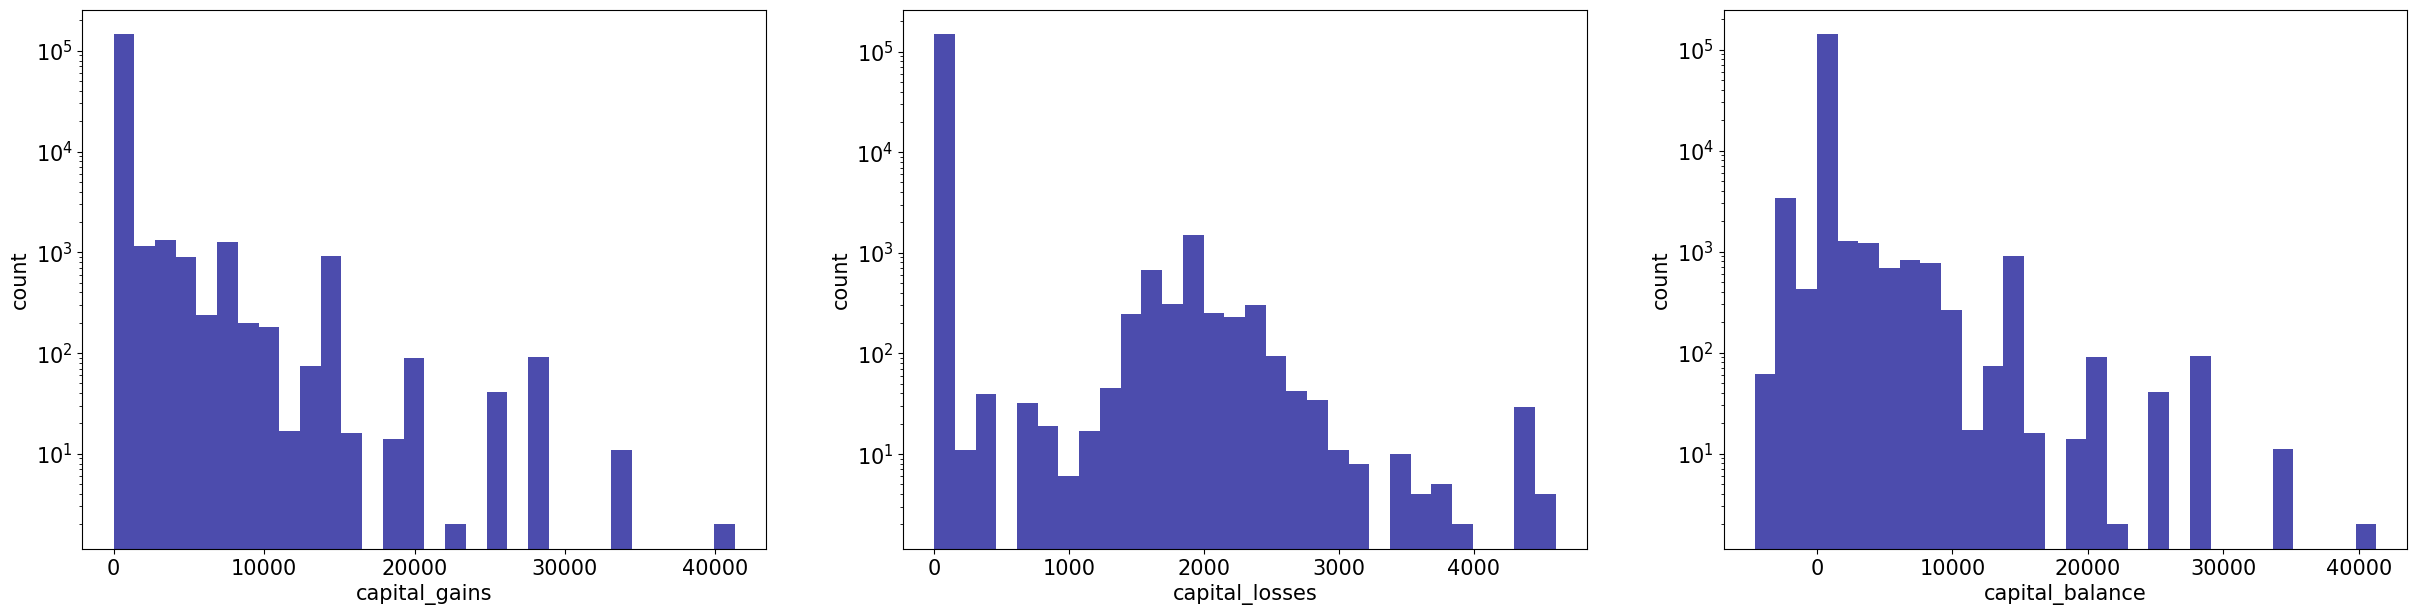

In [59]:
df1['capital_balance'] = df1['capital_gains'] - df1['capital_losses']
fig, axes = plt.subplots(1, 3, figsize=(30, 7))
for i, col in enumerate(['capital_gains', 'capital_losses', 'capital_balance']):
    # enlarge the text size
    df1[col].plot(kind='hist', logy=True, bins=30, ax=axes[i], color='darkblue', alpha=0.7, fontsize=15)
    axes[i].set_xlabel(col, fontsize=15)
    axes[i].set_ylabel('count', fontsize=15)
plt.show()

df1 = df1.drop(['capital_gains', 'capital_losses'], axis=1)

We scale the remaining numerical variables.

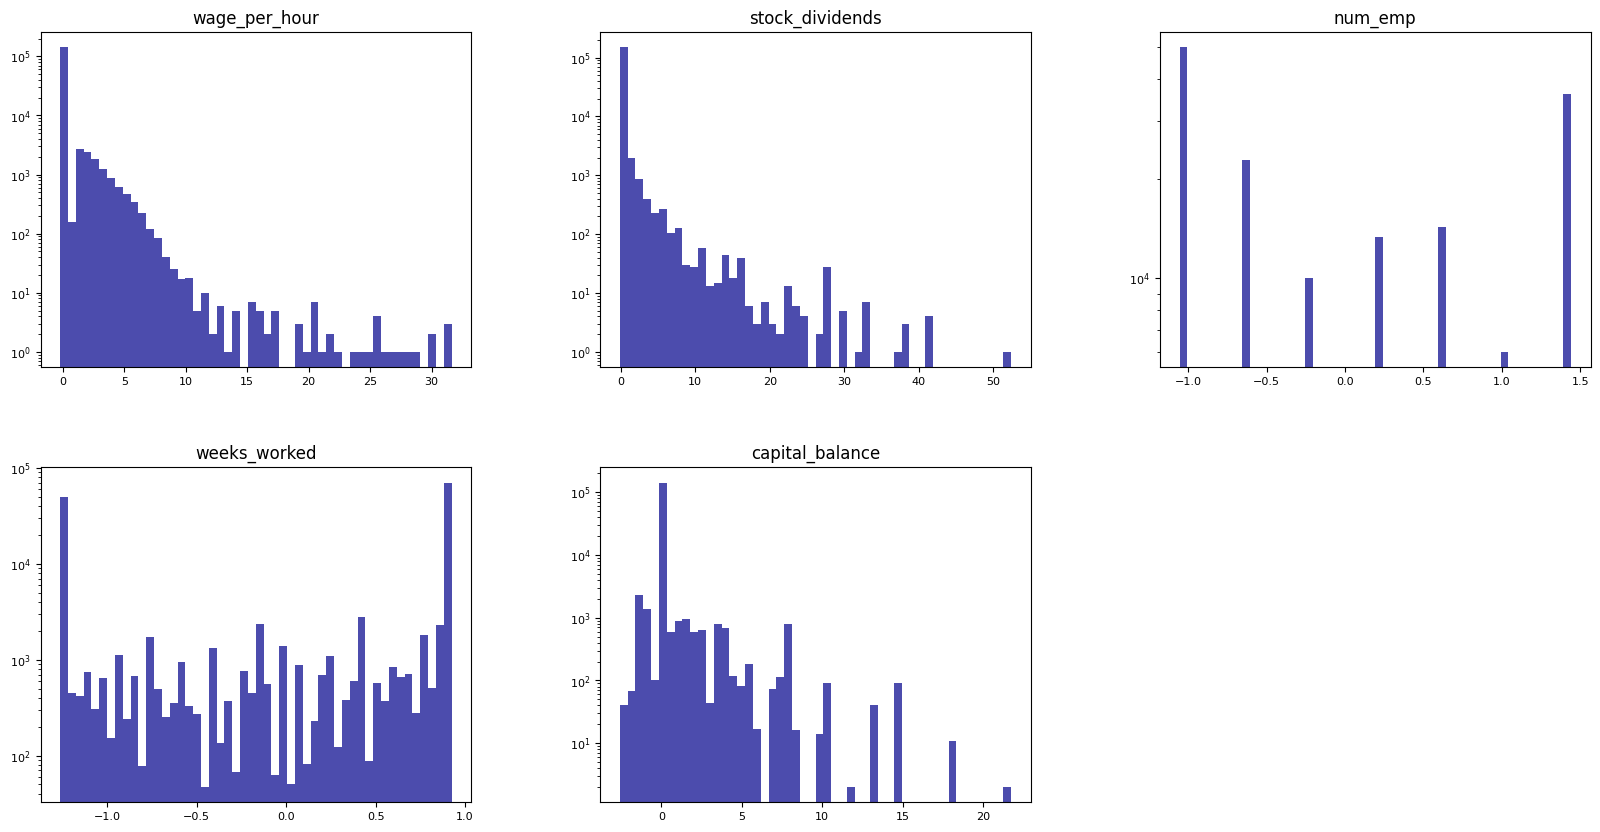

In [60]:
# scale the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

num_cols = df1.select_dtypes(include=['int64', 'float64']).columns
df1[num_cols] = scaler.fit_transform(df1[num_cols])

df1.hist(figsize=(20,10), bins=50, layout=(2, 3), log=True,
         xlabelsize=8, ylabelsize=8, grid=False, color='darkblue', alpha=0.7)
plt.show()

In [61]:
# convert all object columns type to category type
for col in df1.select_dtypes(include=['object']).columns:
    df1[col] = df1[col].astype('category')